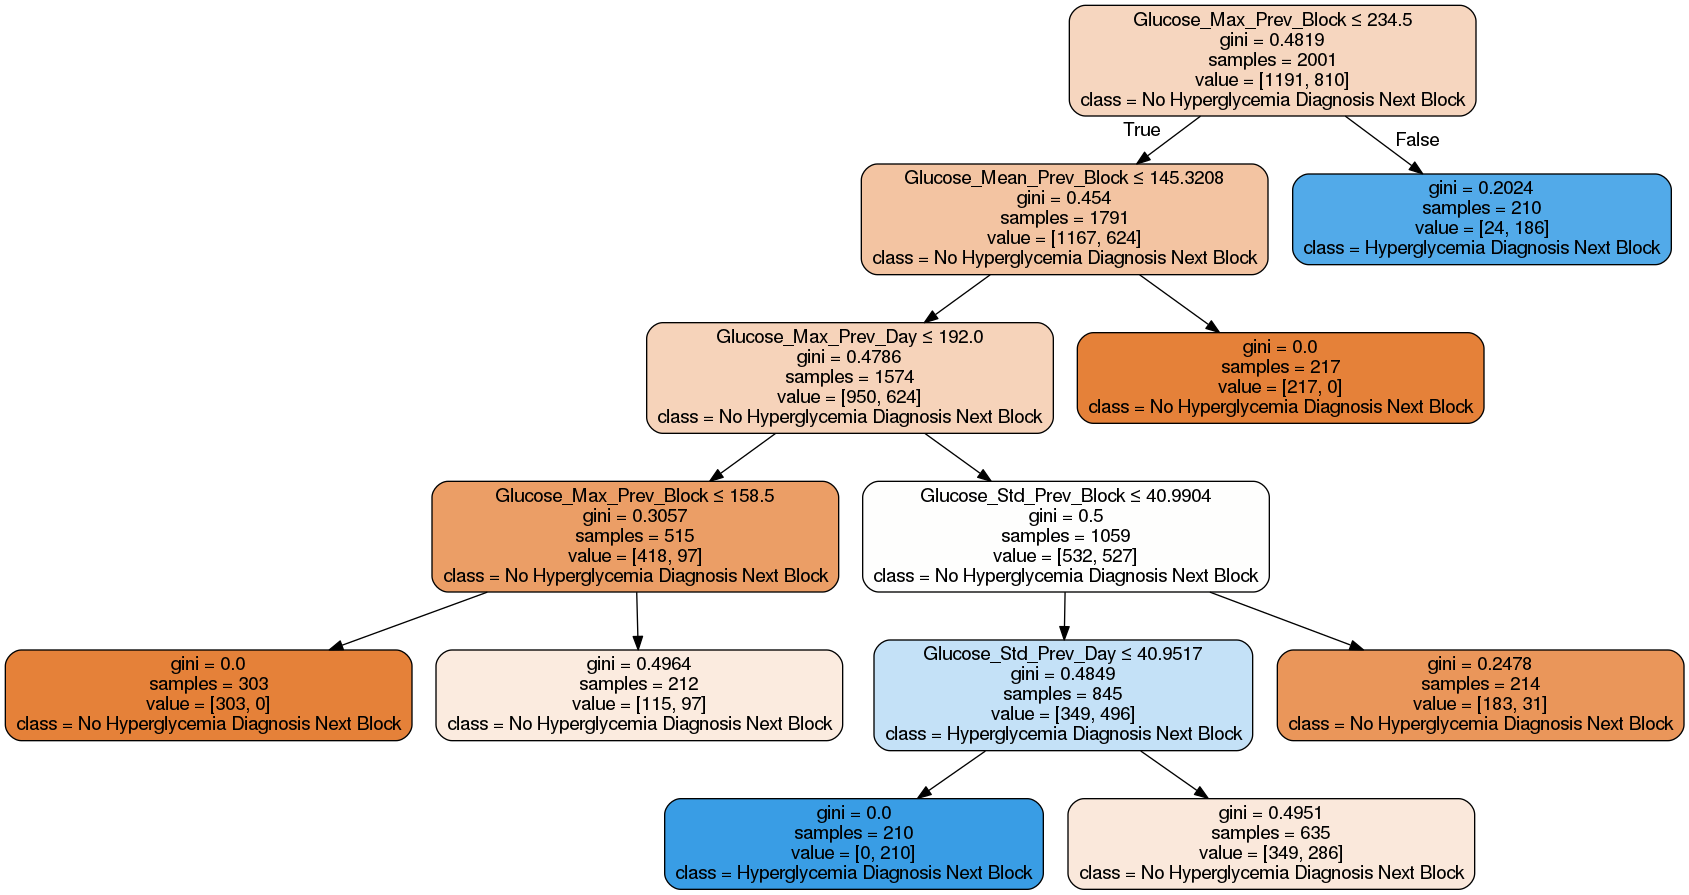

In [2]:
% matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
from IPython.display import Image


# Add modules path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from model.Translator import Translator
from model.DecisionTree import DecisionTree
from model.Rule import Rule
from model.Pattern import Pattern
import preprocessor as pp


# Add modules path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Define language and translator functions
language = "es"
translator = Translator(language)
to_lang = translator.translate_to_language
to_col = translator.translate_to_column

# Load data
raw_data = pd.read_csv("sample.txt", header=0, skiprows=1, delimiter="\t", index_col=0, usecols=list(range(0, 9)),
                       parse_dates=to_lang(["Datetime"]), decimal=",",
                       date_parser=lambda x: pd.to_datetime(x, format="%Y/%m/%d %H:%M"))
# Translate column names
raw_data.columns = (to_col(raw_data.columns))

# Divide in blocks, extend dataset and clean data
block_data = pp.define_blocks(raw_data)
cleaned_block_data = pp.clean_processed_data(block_data)
extended_data = pp.extend_data(cleaned_block_data)
cleaned_extended_data = pp.clean_extended_data(extended_data)

# Create decision trees
[data, labels] = pp.prepare_to_decision_trees (cleaned_extended_data)
hyper_dt = DecisionTree(data, labels["Hyperglycemia_Diagnosis_Next_Block"])
hypo_dt = DecisionTree(data, labels["Hypoglycemia_Diagnosis_Next_Block"])
severe_dt = DecisionTree(data, labels["Severe_Hyperglycemia_Diagnosis_Next_Block"])
Image(hyper_dt.graph.create_png())

In [3]:
def get_decisions (tree, children_left, children_right, decisions, stack, node_id, are_leaves):

    feature = tree.feature
    threshold = tree.threshold
    impurity = tree.impurity
    samples = tree.n_node_samples
    value = tree.value
    
    left_node = children_left[node_id]
    right_node = children_right[node_id]
    decisions.insert(node_id,stack)
    value_neg = value[node_id][0][0]
    value_pos = value[node_id][0][1]
    class_str = 'Negative' if value_neg > value_pos else 'Positive'
    if left_node != right_node:
        stack_left = stack + [
            {'Feature': int(feature[node_id]), 'Operator': '<=', 'Threshold': threshold[node_id], 
             'Impurity': impurity[node_id], 'Samples': samples[node_id], 'Number_Neg': value[node_id][0][0],
             'Number_Pos': value[node_id][0][1], 'Class': class_str}
        ]
        stack_right = stack + [
            {'Feature': int(feature[node_id]), 'Operator': '>', 'Threshold': threshold[node_id], 
             'Impurity': impurity[node_id], 'Samples': samples[node_id], 'Number_Neg': value[node_id][0][0],
             'Number_Pos': value[node_id][0][1], 'Class': class_str}
        ]
        get_decisions (tree, children_left, children_right, decisions, stack_left, left_node, are_leaves)
        get_decisions (tree, children_left, children_right, decisions, stack_right, right_node, are_leaves)
    else:
        are_leaves[node_id] = True
        stack += [
            {'Impurity': impurity[node_id], 'Samples': samples[node_id], 'Number_Neg': value_neg,
             'Number_Pos': value_pos, 'Class': class_str}
        ]
        decisions.insert(node_id, stack)

In [7]:
def getPatterns(tree, max_impurity=0.5, min_sample_size=0):
    
    n_nodes = tree.node_count
    children_left = tree.children_left
    children_right = tree.children_right
    num_records = tree.n_node_samples[0]

    are_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [] 
    decisions = []
    
    get_decisions (tree, children_left, children_right, decisions, stack, 0, are_leaves)
    for id_node, node in enumerate(decisions):
        for idx_decision, decision in enumerate(decisions[id_node]):
            if 'Feature' in decisions[id_node][idx_decision]:
                feature_idx = decisions[id_node][idx_decision]['Feature']
                if isinstance(feature_idx, int):
                    value = data.columns.values[feature_idx]
                    decisions[id_node][idx_decision]['Feature'] = value
    leaves = []
    for idx, leaf in enumerate(are_leaves):
        if leaf:
            leaves.append(decisions[idx])
    patterns = []
    # Last element contains the leaf information
    valid_leaves = [leaf for leaf in leaves if leaf[-1]['Class'] == 'Positive']
    for leaf in valid_leaves:
        rules = [Rule(node["Feature"], node["Operator"], node["Threshold"], translator) for node in leaf[:-1]]
        pattern =  Pattern(rules, num_records, leaf[-1]["Samples"], leaf[-1]["Impurity"], leaf[-1]["Number_Pos"], leaf[-1]["Number_Neg"])
        if pattern.sample_size > min_sample_size and pattern.impurity < max_impurity:
            patterns.append(pattern)
           
    return patterns

In [5]:
tree = hyper_dt.tree
patterns = getPatterns(tree)
for pattern in patterns:
    print (pattern, end='\n\n')

Reglas:
	Nivel de glucosa máximo del bloque anterior es mayor que 234.5
Muestras: 210 (10.49%)
Impureza: 0.2024
Número de muestras positivas: 186
Número de muestras negativas: 24




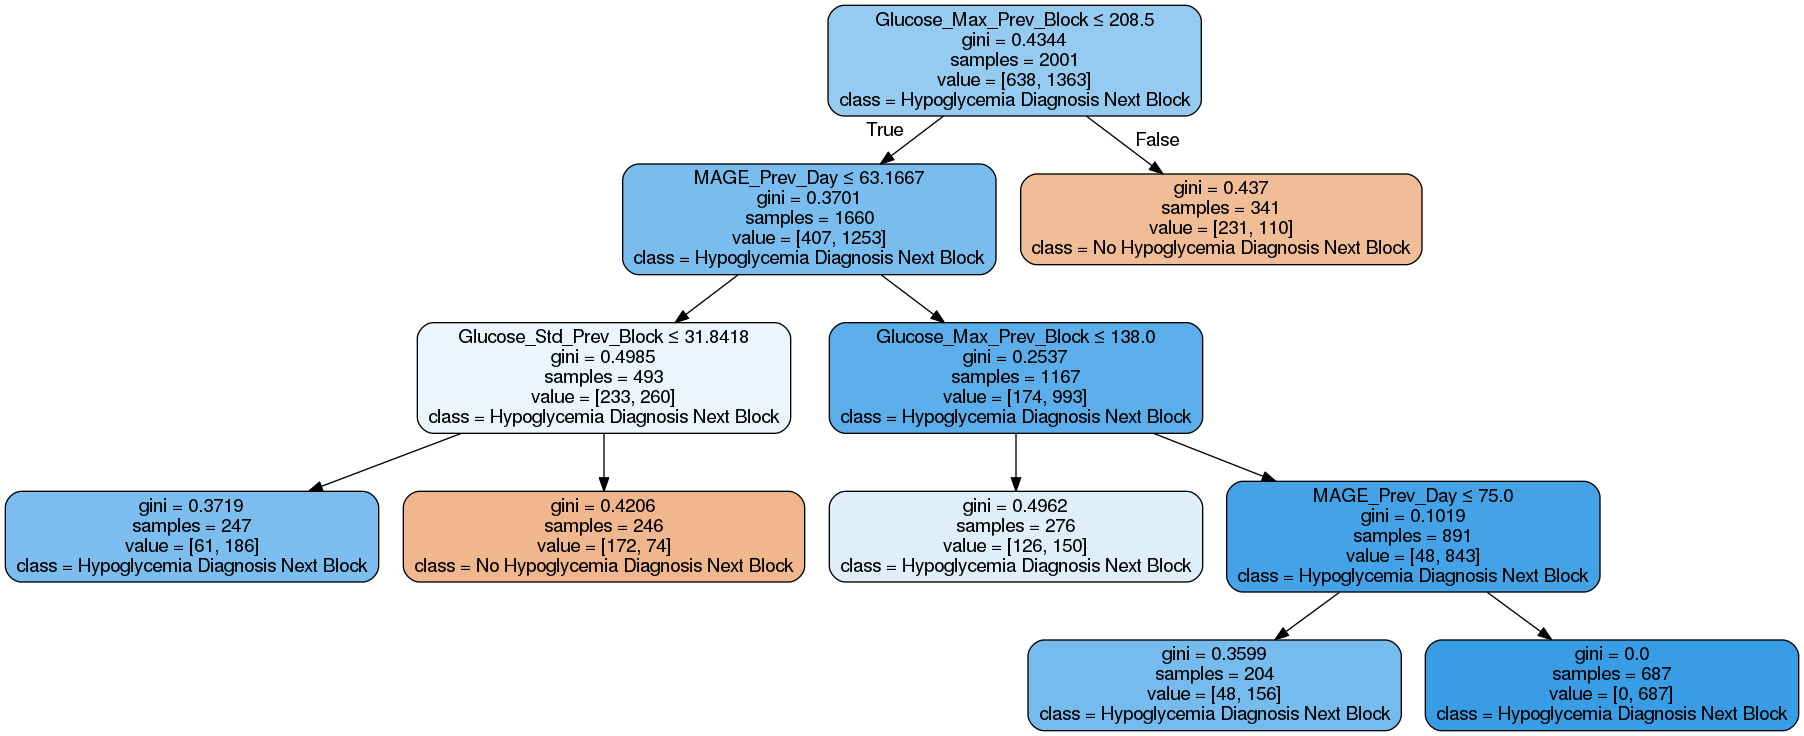

In [6]:
tree = hypo_dt.tree
Image(hypo_dt.graph.create_png())

In [9]:
patterns = getPatterns(tree, max_impurity=0.2)
for pattern in patterns:
    print (pattern, end='\n\n')

Reglas:
	Nivel de glucosa máximo del bloque anterior es mayor que 138 y es menor o igual que 208.5
	Variabilidad glucémica (MAGE) del día anterior es mayor que 75
Muestras: 687 (34.33%)
Impureza: 0
Número de muestras positivas: 687
Número de muestras negativas: 0


